In [2]:
import os
import logging
import pandas as pd
from typing import Optional
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
def read_csv_file(file_path: str) -> Optional[pd.DataFrame]:
    """
    Reads a CSV file using ";" as separator and "," as decimal separator.
    
    Parameters:
        file_path (str): Path to the CSV file.
    
    Returns:
        Optional[pd.DataFrame]: The loaded DataFrame, or None if an error occurs.
    """
    try:
        df = pd.read_csv(file_path, sep=";", decimal=",")
        return df
    except Exception as e:
        logging.error(f"Error reading file {file_path}: {e}")
        return None

def load_df(problemsize: int, earlystop: str) -> pd.DataFrame:
    """
    Loads and concatenates all CSV files from the directory structure:
        Data/ProS_{problemsize}/Es_{earlystop}
    
    Parameters:
        problemsize (int): The problem size.
        earlystop (str): The early stop flag (true, false).
    
    Returns:
        pd.DataFrame: Combined DataFrame with data from all CSV files.
    """
    base_dir = f"Data/ProS_{problemsize}/Es_{earlystop}"
    files_list = []

    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith(".csv"):
                file_path = os.path.join(root, file)
                files_list.append(file_path)

    logging.info(f"Found {len(files_list)} CSV files in {base_dir}")

    dataframes = []
    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(read_csv_file, file_path): file_path for file_path in files_list}
        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing files"):
            df = future.result()
            if df is not None:
                dataframes.append(df)

    if dataframes:
        combined_df = pd.concat(dataframes, ignore_index=True)
        logging.info(f"Combined DataFrame shape: {combined_df.shape}")
    else:
        logging.warning("No CSV files were successfully read. Returning an empty DataFrame.")
        combined_df = pd.DataFrame()

    return combined_df


In [40]:
import pandas as pd

def generate_tables(data):
    """
    Generate summary tables for the evolutionary algorithm performance analysis.

    Assumes 'data' is a DataFrame containing all evaluations with at least the following columns:
      - Evaluations, BestFitness, MeanFitness, Diversity, UniqueIndividuals,
        PopulationSize, ProblemSize, BitFlipProbability, CrossoverProbability, RandomSeed.

    The function extracts the final record of each run (i.e., the row with the maximum Evaluations per group)
    and produces:
      - fitness_summary: Summary of the final BestFitness.
      - diversity_summary: Summary of the final Diversity.
      - evaluations_summary: Summary of the Evaluations used.

    It prints each summary and returns a dictionary with the three tables.
    """
    final_records = data.sort_values('Evaluations', ascending=False) \
        .drop_duplicates(subset=['BitFlipProbability', 'CrossoverProbability', 'RandomSeed']) \
        .reset_index(drop=True)



    fitness_summary = final_records.groupby(['BitFlipProbability', 'CrossoverProbability']).agg(
        MeanFinalFitness=('MeanFitness', 'mean'),
        StdFinalFitness=('MeanFitness', 'std'),
        MaxFinalFitness=('MeanFitness', 'max'),
        MinFinalFitness=('MeanFitness', 'min')
    ).reset_index()

    diversity_summary = final_records.groupby(['BitFlipProbability', 'CrossoverProbability']).agg(
        MeanFinalDiversity=('Diversity', 'mean'),
        StdFinalDiversity=('Diversity', 'std'),
        MaxFinalDiversity=('Diversity', 'max'),
        MinFinalDiversity=('Diversity', 'min')
    ).reset_index()

    evaluations_summary = final_records.groupby(['BitFlipProbability', 'CrossoverProbability']).agg(
        MeanEvaluations=('Evaluations', 'mean'),
        StdEvaluations=('Evaluations', 'std'),
        MinEvaluations=('Evaluations', 'min'),
        MaxEvaluations=('Evaluations', 'max')
    ).reset_index()

    print("Fitness Summary:")
    display(fitness_summary)
    print("\nDiversity Summary:")
    display(diversity_summary)
    print("\nEvaluations Summary:")
    display(evaluations_summary)

    return {
        "fitness_summary": fitness_summary,
        "diversity_summary": diversity_summary,
        "evaluations_summary": evaluations_summary
    }


In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def generate_plots(data):
    """
    Generates a comprehensive set of plots for analyzing the performance of the evolutionary algorithm.
    
    Assumes 'data' is a DataFrame with all evaluations and contains at least the following columns:
      - Evaluations, BestFitness, MeanFitness, Diversity, UniqueIndividuals,
        PopulationSize, ProblemSize, BitFlipProbability, CrossoverProbability, RandomSeed.
      
    The following plots are generated:
      1. Heatmap: Mean final BestFitness (grouped by BitFlipProbability and CrossoverProbability).
      2. Heatmap: Mean final Diversity (grouped by BitFlipProbability and CrossoverProbability).
      3. Scatter Plot: BestFitness vs. Diversity (final records) distinguishing both probabilities.
      4. Line Plot: Evolution of MeanFitness over Evaluations, distinguishing BitFlipProbability (hue)
         and CrossoverProbability (style).
      5. Line Plot: Evolution of Diversity over Evaluations, distinguishing BitFlipProbability (hue)
         and CrossoverProbability (style).
      6. Violin Plot + Swarm Plot: Final distribution of BestFitness by parameter combination.
      7. Violin Plot + Swarm Plot: Final distribution of Diversity by parameter combination.
      8. Boxplot: Final distribution of BestFitness by BitFlipProbability and CrossoverProbability.
      9. Heatmap: Correlation between final metrics.
      10. Line Plot: Delta BestFitness over Evaluations.
    """
    # 1) Extract final records (row with max Evaluations per group)
    group_cols = ['BitFlipProbability', 'CrossoverProbability', 'RandomSeed']
    idx = data.groupby(group_cols)['Evaluations'].idxmax().dropna()
    final_records = data.loc[data.groupby(group_cols)['Evaluations'].idxmax()].reset_index(drop=True)

    # 2) Heatmap: Mean final BestFitness
    fitness_summary = final_records.groupby(['BitFlipProbability', 'CrossoverProbability']).agg(
        MeanFinalFitness=('BestFitness', 'mean')
    ).reset_index()
    pivot_fitness = fitness_summary.pivot(index="BitFlipProbability",
                                          columns="CrossoverProbability",
                                          values="MeanFinalFitness")
    if pivot_fitness.empty:
        print("Warning: pivot_fitness is empty. The MeanFitness heatmap will not be generated.")
    else:
        plt.figure(figsize=(8, 6))
        sns.heatmap(pivot_fitness, annot=True, fmt=".2f", cmap="magma")
        plt.title("Heatmap: Mean Final MeanFitness")
        plt.xlabel("Crossover Probability")
        plt.ylabel("BitFlip Probability")
        plt.show()

    # 3) Heatmap: Mean final Diversity
    diversity_summary = final_records.groupby(['BitFlipProbability', 'CrossoverProbability']).agg(
        MeanFinalDiversity=('Diversity', 'mean')
    ).reset_index()
    pivot_diversity = diversity_summary.pivot(index="BitFlipProbability",
                                              columns="CrossoverProbability",
                                              values="MeanFinalDiversity")
    if pivot_diversity.empty:
        print("Warning: pivot_diversity is empty. The Diversity heatmap will not be generated.")
    else:
        plt.figure(figsize=(8, 6))
        sns.heatmap(pivot_diversity, annot=True, fmt=".2f", cmap="inferno")
        plt.title("Heatmap: Mean Final Diversity")
        plt.xlabel("Crossover Probability")
        plt.ylabel("BitFlip Probability")
        plt.show()

    # 4) Scatter Plot: MeanFitness vs. Diversity (final records)
    if not final_records.empty:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(
            data=final_records,
            x="MeanFitness",
            y="Diversity",
            hue="BitFlipProbability",
            style="CrossoverProbability",
            palette="Set1",
            s=100
        )
        plt.title("Scatter: MeanFitness vs. Diversity (Final)")
        plt.xlabel("MeanFitness")
        plt.ylabel("Diversity")
        plt.show()
    else:
        print("Warning: No final records for the Scatter Plot.")

    # 5) Line Plot: Evolution of MeanFitness over Evaluations
    if not data.empty:
        plt.figure(figsize=(10, 6))
        sns.lineplot(
            data=data,
            x="Evaluations",
            y="MeanFitness",
            hue="BitFlipProbability",
            style="CrossoverProbability",
            estimator='mean',
            errorbar='sd',
            palette="tab10"
        )
        plt.title("Evolution of MeanFitness over Evaluations")
        plt.xlabel("Evaluations")
        plt.ylabel("MeanFitness")
        max_val = data["MeanFitness"].max()
        plt.ylim(max_val * 0.75, max_val)
        plt.legend(title="BitFlipProbability / CrossoverProbability")
        plt.show()
    else:
        print("Warning: The DataFrame is empty. MeanFitness evolution plot will not be generated.")

    # 6) Line Plot: Evolution of Diversity over Evaluations
    if not data.empty:
        plt.figure(figsize=(10, 6))
        sns.lineplot(
            data=data,
            x="Evaluations",
            y="Diversity",
            hue="BitFlipProbability",
            style="CrossoverProbability",
            estimator='mean',
            errorbar='sd',
            palette="tab10"
        )
        plt.title("Evolution of Diversity over Evaluations")
        plt.xlabel("Evaluations")
        plt.ylabel("Diversity")
        plt.legend(title="BitFlipProbability / CrossoverProbability")
        plt.show()
    else:
        print("Warning: The DataFrame is empty. Diversity evolution plot will not be generated.")

    # 7) Violin Plot + Swarm Plot: Final distribution of MeanFitness by parameter combination
    if not final_records.empty:
        final_records = final_records.copy()
        final_records["Params"] = final_records.apply(
            lambda row: f"BFP={row['BitFlipProbability']:.2f}, CP={row['CrossoverProbability']:.2f}",
            axis=1
        )
        unique_params = final_records.sort_values(["BitFlipProbability", "CrossoverProbability"])["Params"].unique()

        plt.figure(figsize=(14, 6))
        sns.violinplot(
            data=final_records,
            x="Params",
            y="MeanFitness",
            order=unique_params,
            cut=0,
            palette="Pastel1",
            bw_method=0.2
        )
        sns.swarmplot(
            data=final_records,
            x="Params",
            y="MeanFitness",
            order=unique_params,
            color="k",
            alpha=0.6,
            size=0.01
        )
        plt.title("Violin Plot: Final Distribution of MeanFitness")
        plt.xlabel("Parameter Combination (BFP, CP)")
        plt.ylabel("MeanFitness (Final)")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        # 8) Violin Plot + Swarm Plot: Final distribution of Diversity by parameter combination
        plt.figure(figsize=(14, 6))
        sns.violinplot(
            data=final_records,
            x="Params",
            y="Diversity",
            order=unique_params,
            cut=0,
            palette="Pastel2",
            bw_method=0.4
        )
        sns.swarmplot(
            data=final_records,
            x="Params",
            y="Diversity",
            order=unique_params,
            color="k",
            alpha=0.6,
            size=0.01
        )
        plt.title("Violin Plot: Final Distribution of Diversity")
        plt.xlabel("Parameter Combination (BFP, CP)")
        plt.ylabel("Diversity (Final)")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        # 9) Boxplot: Final distribution of MeanFitness by BitFlipProbability and CrossoverProbability
        plt.figure(figsize=(10, 6))
        sns.boxplot(
            data=final_records,
            x="BitFlipProbability",
            y="MeanFitness",
            hue="CrossoverProbability",
            palette="Paired"
        )
        plt.title("Boxplot: Final MeanFitness by BitFlipProbability and CrossoverProbability")
        plt.xlabel("BitFlipProbability")
        plt.ylabel("MeanFitness (Final)")
        plt.legend(title="CrossoverProbability")
        plt.show()

        # 10) Heatmap: Correlation between final metrics
        agg_data = final_records[['BestFitness', 'MeanFitness', 'Diversity', 'Evaluations']].copy()
        plt.figure(figsize=(8, 6))
        sns.heatmap(agg_data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
        plt.title("Heatmap: Correlation Between Final Metrics")
        plt.show()

    else:
        print("Warning: There are no final records for the final distribution plots.")

2025-02-16 22:42:55,976 - INFO - Found 2970 CSV files in Data/ProS_25/Es_false
Processing files: 100%|██████████| 2970/2970 [00:12<00:00, 231.78it/s]
2025-02-16 22:43:09,615 - INFO - Combined DataFrame shape: (59310900, 10)


,Evaluations,BestFitness,MeanFitness,Diversity,UniqueIndividuals,PopulationSize,ProblemSize,BitFlipProbability,CrossoverProbability,RandomSeed
0,31,20,12.5000,12.4713,29,30,25,0.05,0.0,1
1,32,20,12.6333,12.4851,29,30,25,0.05,0.0,1
2,33,20,12.8667,12.4920,29,30,25,0.05,0.0,1
3,34,20,13.0667,12.4460,29,30,25,0.05,0.0,1
4,35,20,13.1000,12.3517,28,30,25,0.05,0.0,1
...,...,...,...,...,...,...,...,...,...,...
59300895,9996,25,23.1333,3.3885,27,30,25,0.30,1.0,99
59300896,9997,25,23.1333,3.3885,27,30,25,0.30,1.0,99
59300897,9998,25,23.1333,3.3885,27,30,25,0.30,1.0,99
59300898,9999,25,23.1333,3.3885,27,30,25,0.30,1.0,99


Fitness Summary:


,BitFlipProbability,CrossoverProbability,MeanFinalFitness,StdFinalFitness,MaxFinalFitness,MinFinalFitness
0,0.05,0.00,25.000000,0.000000,25.0000,25.0000
1,0.05,0.25,25.000000,0.000000,25.0000,25.0000
2,0.05,0.50,25.000000,0.000000,25.0000,25.0000
3,0.05,0.75,25.000000,0.000000,25.0000,25.0000
4,0.05,1.00,25.000000,0.000000,25.0000,25.0000
5,0.10,0.00,25.000000,0.000000,25.0000,25.0000
6,0.10,0.25,25.000000,0.000000,25.0000,25.0000
7,0.10,0.50,25.000000,0.000000,25.0000,25.0000
8,0.10,0.75,25.000000,0.000000,25.0000,25.0000
9,0.10,1.00,25.000000,0.000000,25.0000,25.0000



Diversity Summary:


,BitFlipProbability,CrossoverProbability,MeanFinalDiversity,StdFinalDiversity,MaxFinalDiversity,MinFinalDiversity
0,0.05,0.00,0.000000,0.000000,0.0000,0.0000
1,0.05,0.25,0.000000,0.000000,0.0000,0.0000
2,0.05,0.50,0.000000,0.000000,0.0000,0.0000
3,0.05,0.75,0.000000,0.000000,0.0000,0.0000
4,0.05,1.00,0.000000,0.000000,0.0000,0.0000
5,0.10,0.00,0.000000,0.000000,0.0000,0.0000
6,0.10,0.25,0.000000,0.000000,0.0000,0.0000
7,0.10,0.50,0.000000,0.000000,0.0000,0.0000
8,0.10,0.75,0.000000,0.000000,0.0000,0.0000
9,0.10,1.00,0.000000,0.000000,0.0000,0.0000



Evaluations Summary:


,BitFlipProbability,CrossoverProbability,MeanEvaluations,StdEvaluations,MinEvaluations,MaxEvaluations
0,0.05,0.00,10000.0,0.0,10000,10000
1,0.05,0.25,10000.0,0.0,10000,10000
2,0.05,0.50,10000.0,0.0,10000,10000
3,0.05,0.75,10000.0,0.0,10000,10000
4,0.05,1.00,10000.0,0.0,10000,10000
5,0.10,0.00,10000.0,0.0,10000,10000
6,0.10,0.25,10000.0,0.0,10000,10000
7,0.10,0.50,10000.0,0.0,10000,10000
8,0.10,0.75,10000.0,0.0,10000,10000
9,0.10,1.00,10000.0,0.0,10000,10000


Resumen de Fitness Final:


,BitFlipProbability,CrossoverProbability,MeanFinalFitness,StdFinalFitness,MaxFinalFitness,MinFinalFitness
0,0.05,0.00,25.000000,0.000000,25.0000,25.0000
1,0.05,0.25,25.000000,0.000000,25.0000,25.0000
2,0.05,0.50,25.000000,0.000000,25.0000,25.0000
3,0.05,0.75,25.000000,0.000000,25.0000,25.0000
4,0.05,1.00,25.000000,0.000000,25.0000,25.0000
5,0.10,0.00,25.000000,0.000000,25.0000,25.0000
6,0.10,0.25,25.000000,0.000000,25.0000,25.0000
7,0.10,0.50,25.000000,0.000000,25.0000,25.0000
8,0.10,0.75,25.000000,0.000000,25.0000,25.0000
9,0.10,1.00,25.000000,0.000000,25.0000,25.0000



Resumen de Diversidad Final:


,BitFlipProbability,CrossoverProbability,MeanFinalDiversity,StdFinalDiversity,MaxFinalDiversity,MinFinalDiversity
0,0.05,0.00,0.000000,0.000000,0.0000,0.0000
1,0.05,0.25,0.000000,0.000000,0.0000,0.0000
2,0.05,0.50,0.000000,0.000000,0.0000,0.0000
3,0.05,0.75,0.000000,0.000000,0.0000,0.0000
4,0.05,1.00,0.000000,0.000000,0.0000,0.0000
5,0.10,0.00,0.000000,0.000000,0.0000,0.0000
6,0.10,0.25,0.000000,0.000000,0.0000,0.0000
7,0.10,0.50,0.000000,0.000000,0.0000,0.0000
8,0.10,0.75,0.000000,0.000000,0.0000,0.0000
9,0.10,1.00,0.000000,0.000000,0.0000,0.0000



Resumen de Evaluaciones:


,BitFlipProbability,CrossoverProbability,MeanEvaluations,StdEvaluations,MinEvaluations,MaxEvaluations
0,0.05,0.00,10000.0,0.0,10000,10000
1,0.05,0.25,10000.0,0.0,10000,10000
2,0.05,0.50,10000.0,0.0,10000,10000
3,0.05,0.75,10000.0,0.0,10000,10000
4,0.05,1.00,10000.0,0.0,10000,10000
5,0.10,0.00,10000.0,0.0,10000,10000
6,0.10,0.25,10000.0,0.0,10000,10000
7,0.10,0.50,10000.0,0.0,10000,10000
8,0.10,0.75,10000.0,0.0,10000,10000
9,0.10,1.00,10000.0,0.0,10000,10000


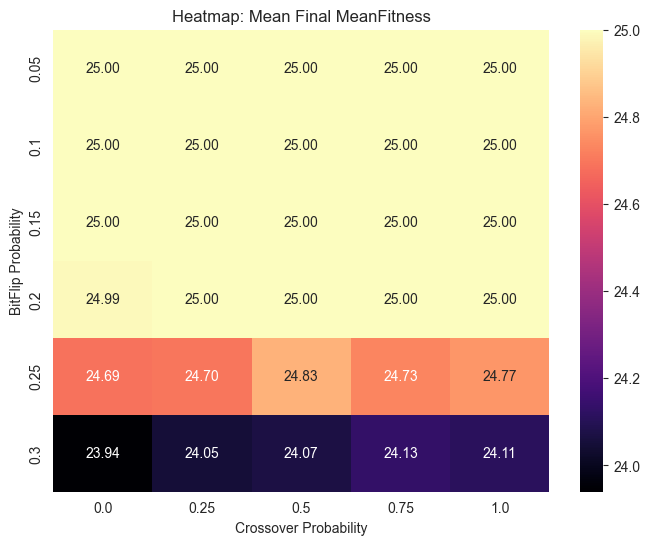

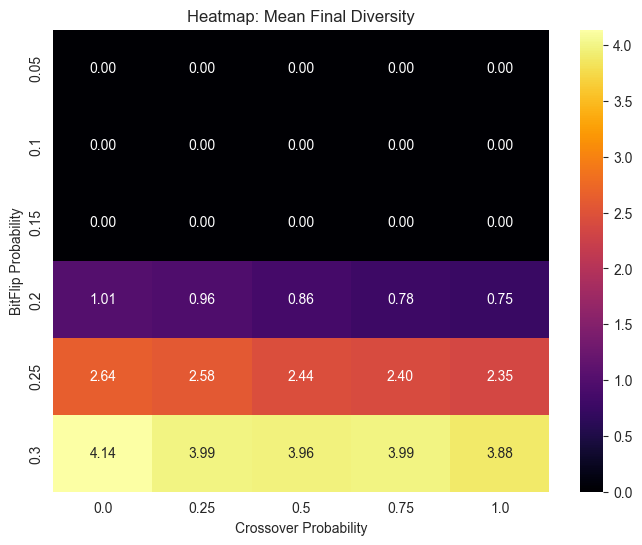

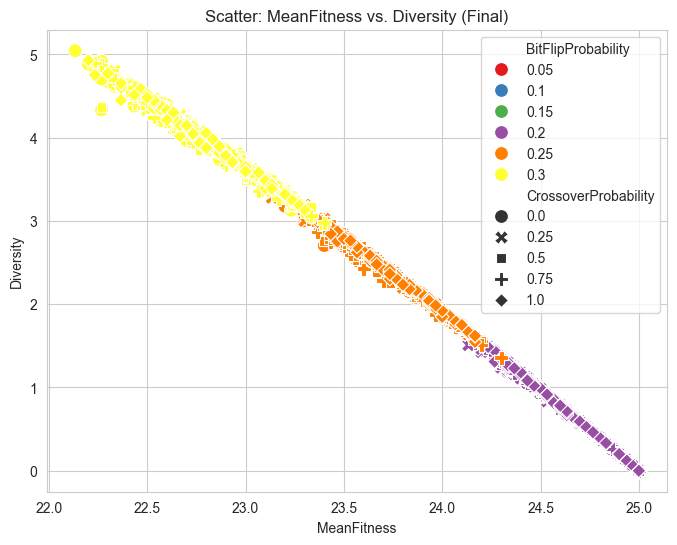

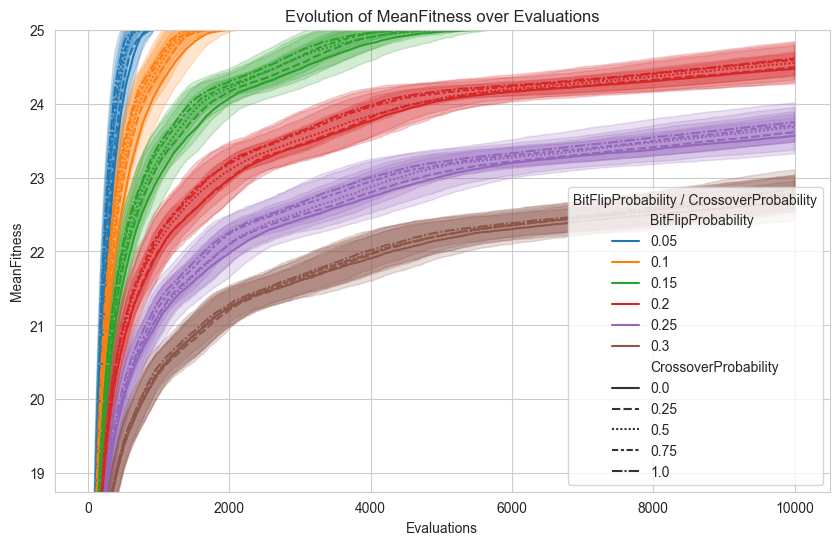

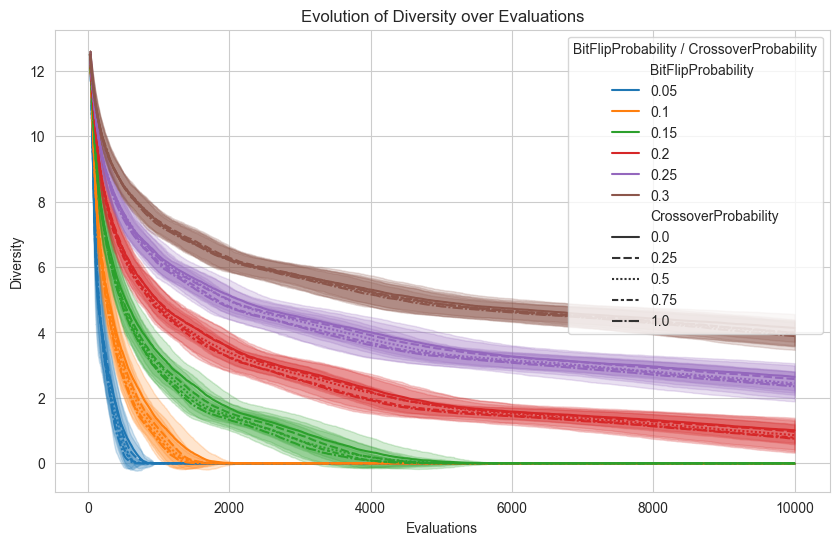

C:\Users\rafac\AppData\Local\Temp\ipykernel_16124\2718358213.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


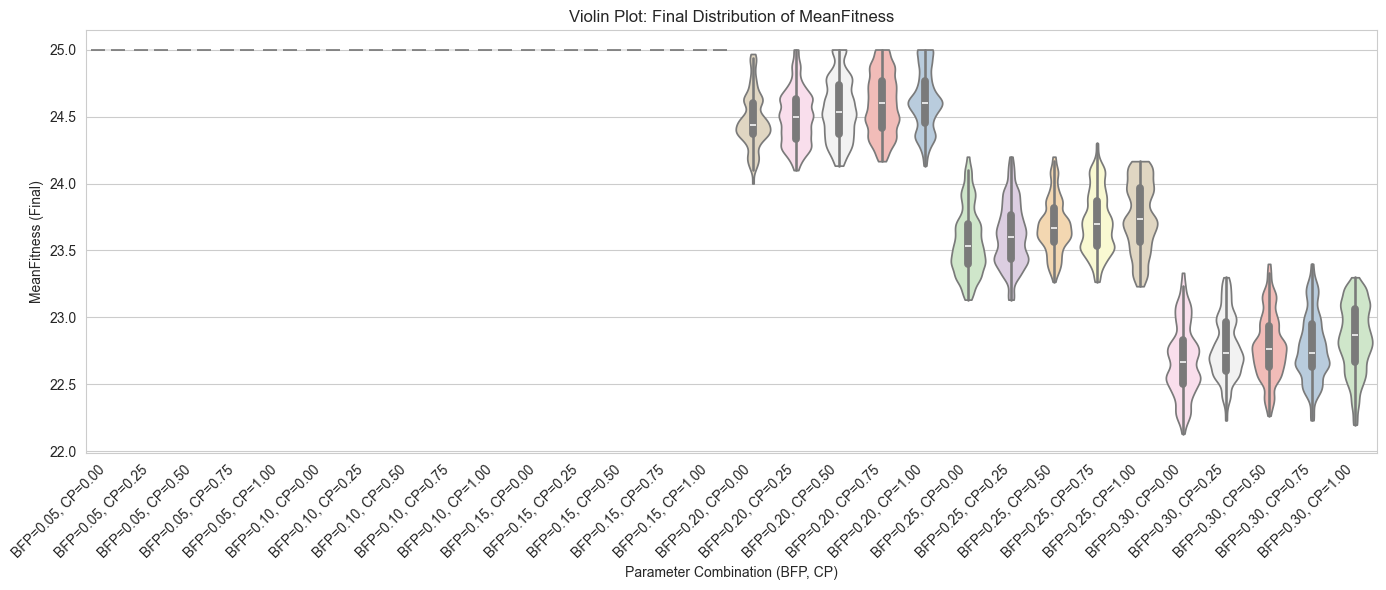

C:\Users\rafac\AppData\Local\Temp\ipykernel_16124\2718358213.py:166: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


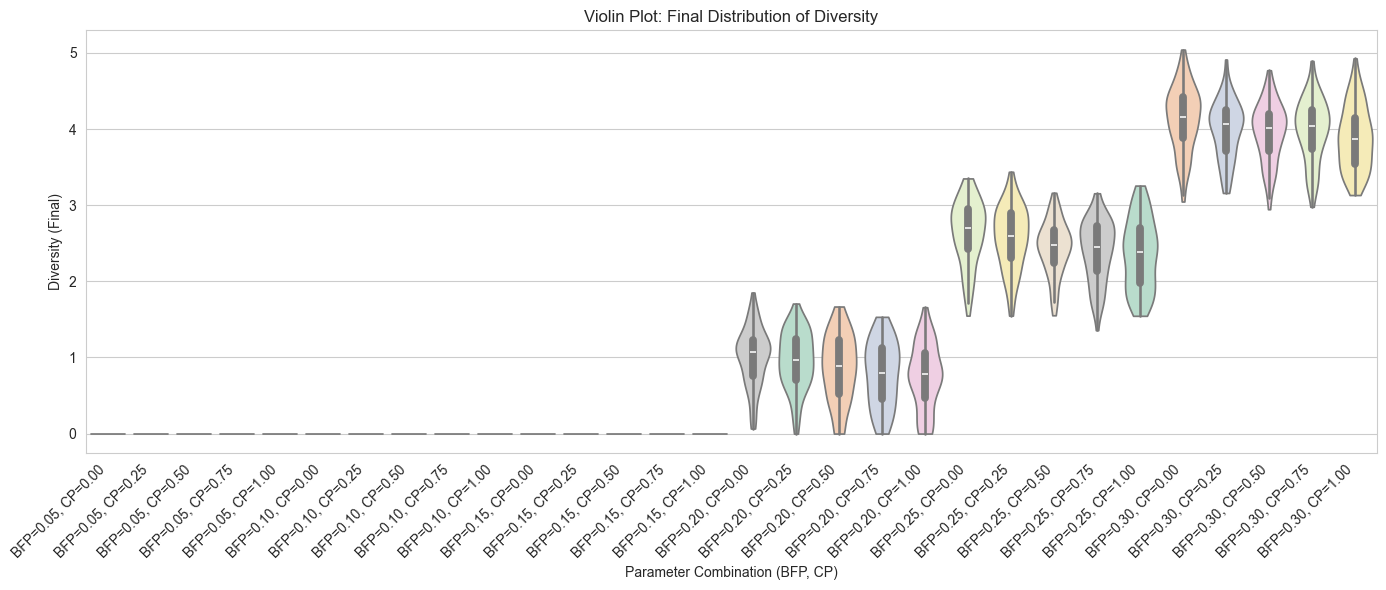

2025-02-16 22:45:42,038 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-02-16 22:45:42,043 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


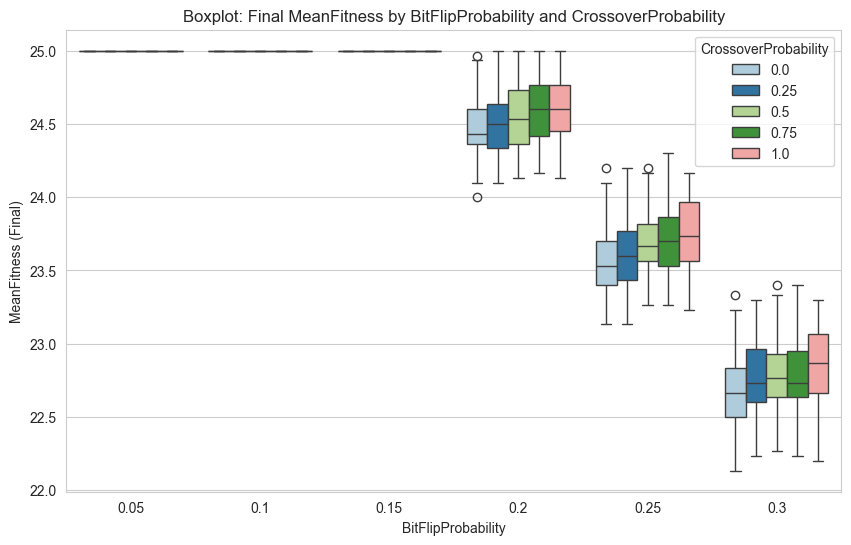

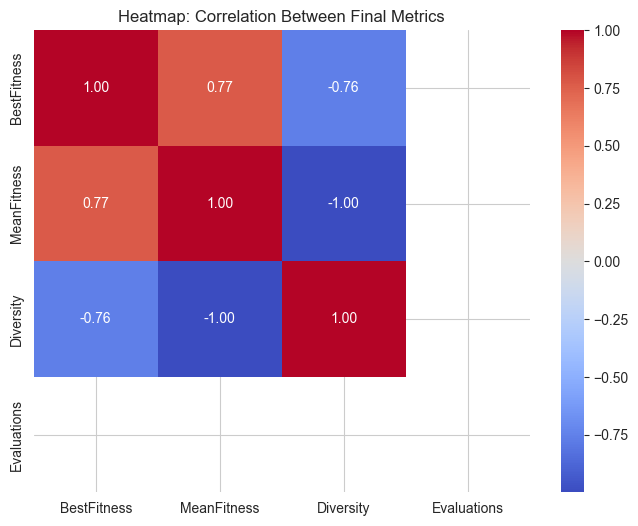

In [49]:
df = load_df(25, "false")
df = df[df["Evaluations"] <= 10000]
# Generar las tablas resumen
display(df)
tables = generate_tables(df)
print("Resumen de Fitness Final:")
display(tables["fitness_summary"])
print("\nResumen de Diversidad Final:")
display(tables["diversity_summary"])
print("\nResumen de Evaluaciones:")
display(tables["evaluations_summary"])
generate_plots(df)

2025-02-16 22:45:42,354 - INFO - Found 2970 CSV files in Data/ProS_25/Es_true
Processing files: 100%|██████████| 2970/2970 [00:04<00:00, 665.87it/s] 
2025-02-16 22:45:47,609 - INFO - Combined DataFrame shape: (14363783, 10)


,Evaluations,BestFitness,MeanFitness,Diversity,UniqueIndividuals,PopulationSize,ProblemSize,BitFlipProbability,CrossoverProbability,RandomSeed
0,31,16,12.5333,12.6207,30,30,25,0.05,0.0,14
1,32,16,12.6333,12.5770,30,30,25,0.05,0.0,14
2,33,16,12.7667,12.4667,29,30,25,0.05,0.0,14
3,34,16,12.9333,12.4874,28,30,25,0.05,0.0,14
4,35,16,13.0667,12.3586,28,30,25,0.05,0.0,14
...,...,...,...,...,...,...,...,...,...,...
14363778,15648,24,23.1667,3.3264,26,30,25,0.30,1.0,98
14363779,15649,24,23.1667,3.3264,26,30,25,0.30,1.0,98
14363780,15650,24,23.1667,3.3264,26,30,25,0.30,1.0,98
14363781,15651,24,23.1667,3.3264,26,30,25,0.30,1.0,98


Fitness Summary:


,BitFlipProbability,CrossoverProbability,MeanFinalFitness,StdFinalFitness,MaxFinalFitness,MinFinalFitness
0,0.05,0.00,23.556219,0.478475,24.0333,21.7667
1,0.05,0.25,23.398646,0.592443,24.0333,20.8667
2,0.05,0.50,23.319189,0.580047,24.0333,21.2000
3,0.05,0.75,23.305389,0.425960,24.0333,22.0000
4,0.05,1.00,23.206399,0.620063,24.0333,20.5000
5,0.10,0.00,23.334341,0.573856,24.0333,19.9333
6,0.10,0.25,23.173734,0.667280,24.0333,20.7333
7,0.10,0.50,23.148485,0.628452,24.0333,20.5667
8,0.10,0.75,23.095618,0.612371,24.0333,21.1333
9,0.10,1.00,23.060271,0.810804,24.0333,18.3000



Diversity Summary:


,BitFlipProbability,CrossoverProbability,MeanFinalDiversity,StdFinalDiversity,MaxFinalDiversity,MinFinalDiversity
0,0.05,0.00,1.517801,0.700188,3.5862,0.0667
1,0.05,0.25,1.854219,0.793695,4.8115,0.0667
2,0.05,0.50,2.015048,0.827554,5.3333,0.1954
3,0.05,0.75,2.139714,0.664718,4.0230,0.1954
4,0.05,1.00,2.317820,0.901771,5.1241,0.1954
5,0.10,0.00,2.475816,0.689540,4.3172,1.1241
6,0.10,0.25,2.781889,0.926403,5.8897,1.3034
7,0.10,0.50,2.908922,0.843990,5.9494,1.4874
8,0.10,0.75,2.981441,0.749163,5.0460,1.5793
9,0.10,1.00,3.097906,1.122210,9.3724,1.0460



Evaluations Summary:


,BitFlipProbability,CrossoverProbability,MeanEvaluations,StdEvaluations,MinEvaluations,MaxEvaluations
0,0.05,0.00,446.454545,97.023380,205,754
1,0.05,0.25,401.797980,93.049798,163,592
2,0.05,0.50,371.575758,99.593571,154,718
3,0.05,0.75,336.666667,73.466499,195,555
4,0.05,1.00,305.929293,71.445891,166,541
5,0.10,0.00,712.929293,215.127454,204,1316
6,0.10,0.25,611.707071,194.693440,231,1048
7,0.10,0.50,548.313131,170.040610,180,911
8,0.10,0.75,510.141414,160.283996,192,921
9,0.10,1.00,473.434343,149.540668,115,875


Resumen de Fitness Final:


,BitFlipProbability,CrossoverProbability,MeanFinalFitness,StdFinalFitness,MaxFinalFitness,MinFinalFitness
0,0.05,0.00,23.556219,0.478475,24.0333,21.7667
1,0.05,0.25,23.398646,0.592443,24.0333,20.8667
2,0.05,0.50,23.319189,0.580047,24.0333,21.2000
3,0.05,0.75,23.305389,0.425960,24.0333,22.0000
4,0.05,1.00,23.206399,0.620063,24.0333,20.5000
5,0.10,0.00,23.334341,0.573856,24.0333,19.9333
6,0.10,0.25,23.173734,0.667280,24.0333,20.7333
7,0.10,0.50,23.148485,0.628452,24.0333,20.5667
8,0.10,0.75,23.095618,0.612371,24.0333,21.1333
9,0.10,1.00,23.060271,0.810804,24.0333,18.3000



Resumen de Diversidad Final:


,BitFlipProbability,CrossoverProbability,MeanFinalDiversity,StdFinalDiversity,MaxFinalDiversity,MinFinalDiversity
0,0.05,0.00,1.517801,0.700188,3.5862,0.0667
1,0.05,0.25,1.854219,0.793695,4.8115,0.0667
2,0.05,0.50,2.015048,0.827554,5.3333,0.1954
3,0.05,0.75,2.139714,0.664718,4.0230,0.1954
4,0.05,1.00,2.317820,0.901771,5.1241,0.1954
5,0.10,0.00,2.475816,0.689540,4.3172,1.1241
6,0.10,0.25,2.781889,0.926403,5.8897,1.3034
7,0.10,0.50,2.908922,0.843990,5.9494,1.4874
8,0.10,0.75,2.981441,0.749163,5.0460,1.5793
9,0.10,1.00,3.097906,1.122210,9.3724,1.0460



Resumen de Evaluaciones:


,BitFlipProbability,CrossoverProbability,MeanEvaluations,StdEvaluations,MinEvaluations,MaxEvaluations
0,0.05,0.00,446.454545,97.023380,205,754
1,0.05,0.25,401.797980,93.049798,163,592
2,0.05,0.50,371.575758,99.593571,154,718
3,0.05,0.75,336.666667,73.466499,195,555
4,0.05,1.00,305.929293,71.445891,166,541
5,0.10,0.00,712.929293,215.127454,204,1316
6,0.10,0.25,611.707071,194.693440,231,1048
7,0.10,0.50,548.313131,170.040610,180,911
8,0.10,0.75,510.141414,160.283996,192,921
9,0.10,1.00,473.434343,149.540668,115,875


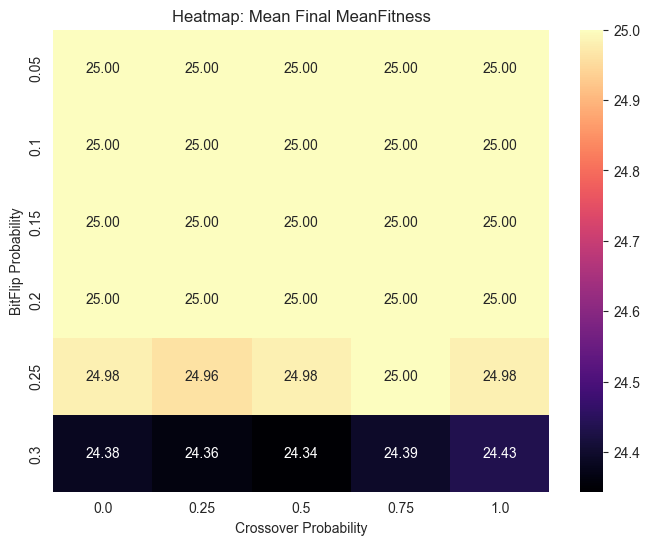

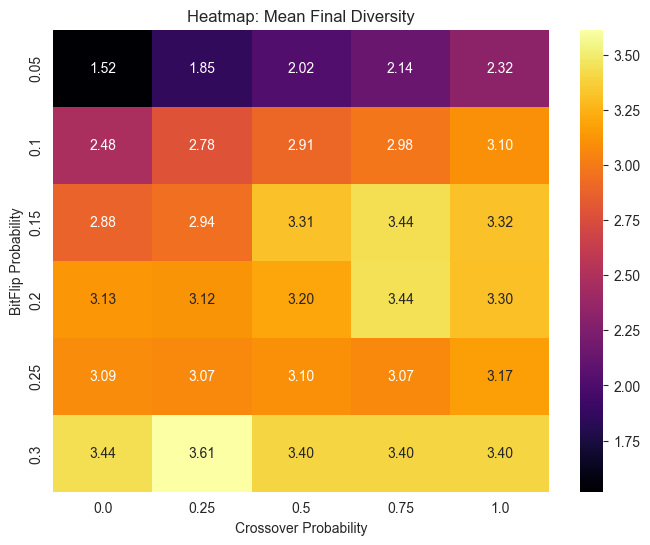

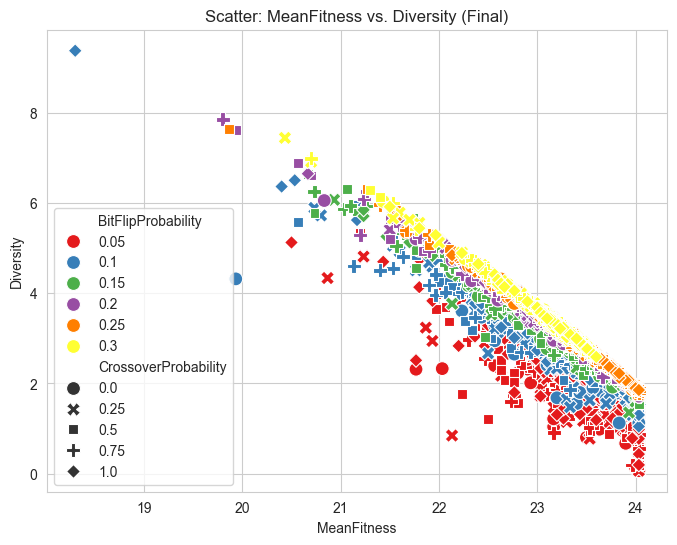

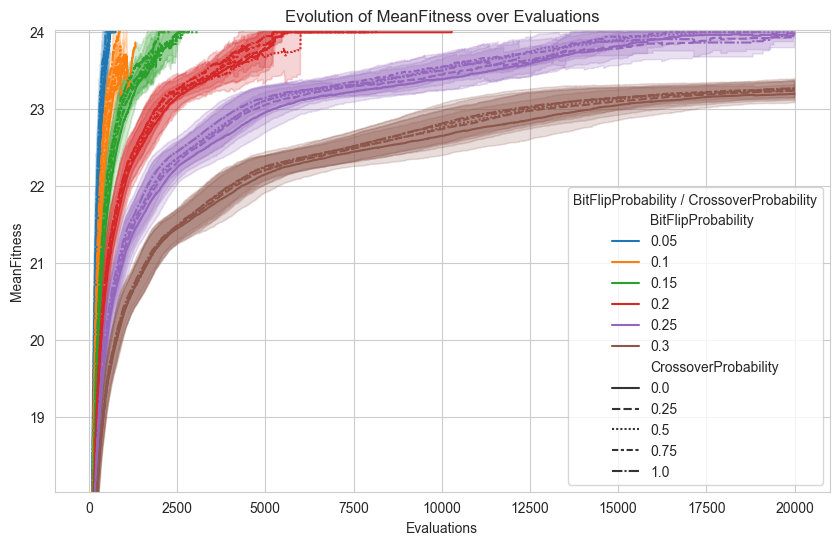

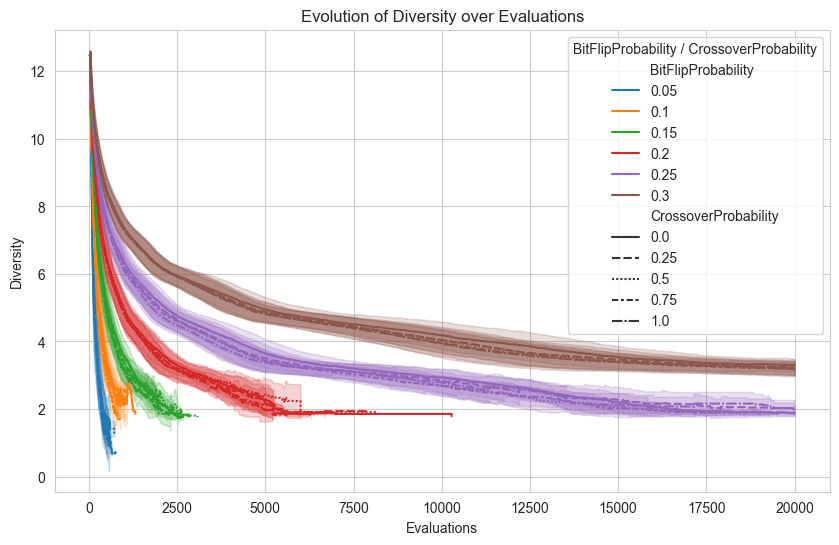

C:\Users\rafac\AppData\Local\Temp\ipykernel_16124\2718358213.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


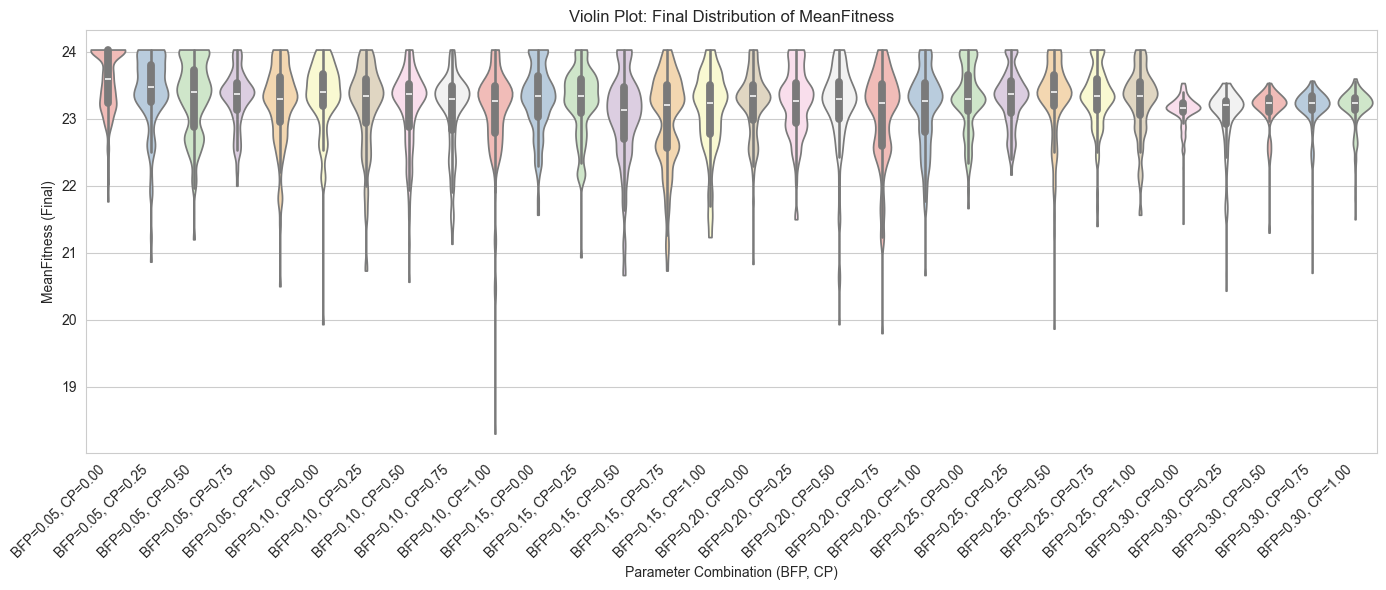

C:\Users\rafac\AppData\Local\Temp\ipykernel_16124\2718358213.py:166: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


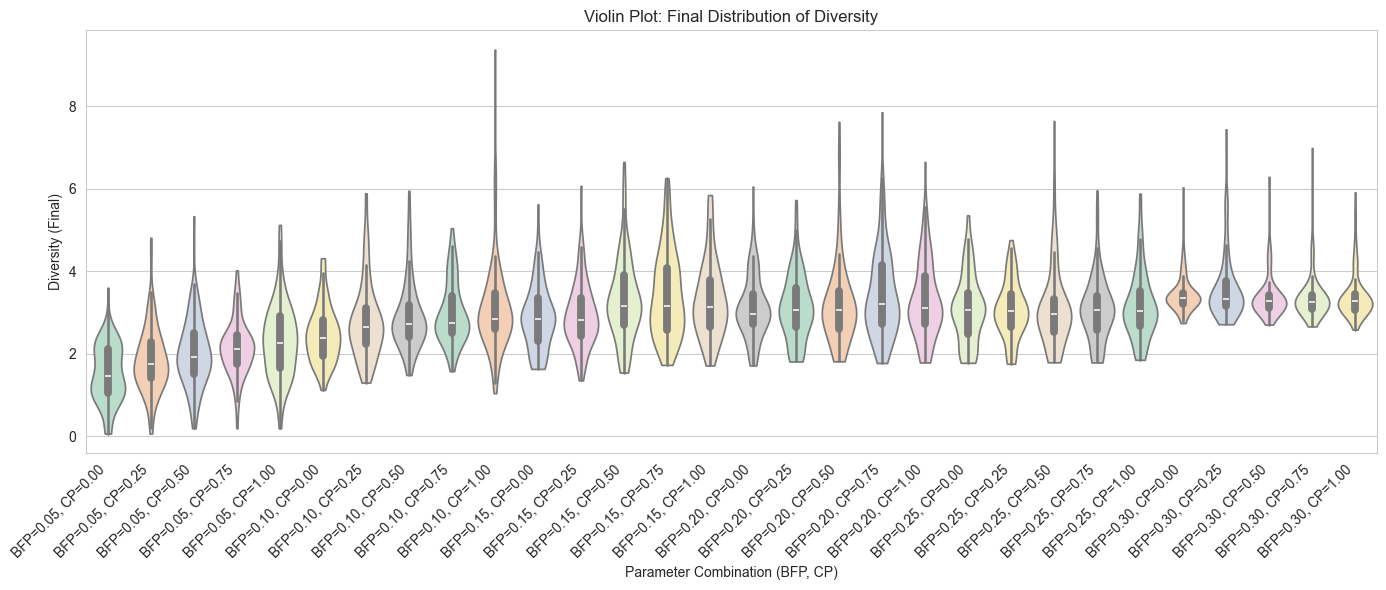

2025-02-16 22:47:32,133 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-02-16 22:47:32,136 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


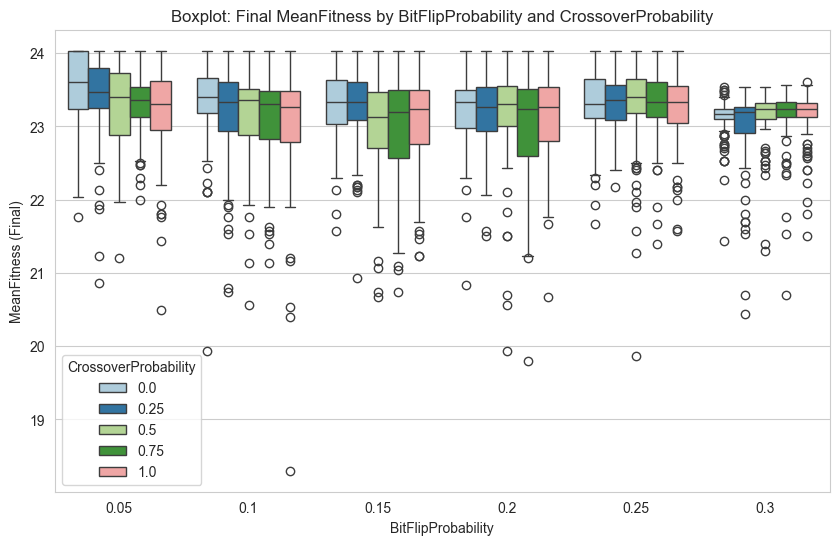

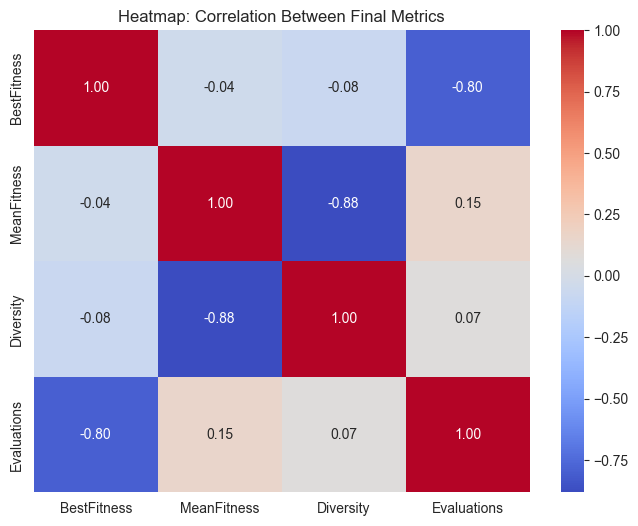

In [50]:
df = load_df(25, "true")
# df = df[df["Evaluations"] <= 100000]
# Generar las tablas resumen
display(df)
tables = generate_tables(df)
print("Resumen de Fitness Final:")
display(tables["fitness_summary"])
print("\nResumen de Diversidad Final:")
display(tables["diversity_summary"])
print("\nResumen de Evaluaciones:")
display(tables["evaluations_summary"])
generate_plots(df)